# Compare normalization of tokens via stemming and lemmatization

In [1]:
# TODO plots of type-token ration and character-token ratio by author and stemming type (similar to Apples to Apple paper)
# TODO measure vocab overlap after pruning
# TODO pull metrics out of diagnostics xml in some informative way 
# TODO Visualize author correlations for each stemmed model in a way that they can be compared
# TODO "Influential Words" and stemming conflation (sec 5.5 in Apples to Apple)
from pathlib import Path

import pandas as pd
import seaborn as sns

from topic_modeling.analysis import *
import topic_modeling.preprocessing as preprocessing


all_stemmers = ['pymystem3', 'snowball', 'stanza', 'truncate']

In [2]:
# Load in original author counts
UNSTEMMED_CORPUS_DIR = Path('/home/virginia/workspace/topic-modeling-study/russian_novels') 
ORIGINAL_CORPUS = UNSTEMMED_CORPUS_DIR / 'russian_novels.tsv'
ORIGINAL_CORPUS_COUNTS = UNSTEMMED_CORPUS_DIR / 'russian_novels_counts.tsv'
ORIGINAL_PRUNED_VOCAB = UNSTEMMED_CORPUS_DIR  / 'russian_novels_pruned_vocab.txt'

## Double check original tokenization
There were some slight differences between unpruned number of tokens between unstemmed, snowball and truncation, let's investigate.


In [11]:
original_tf_df = pd.read_csv(ORIGINAL_CORPUS_COUNTS, sep='\t', encoding='utf-8', names=['token', 'term_freq'], usecols=[0, 1])
print("Dataframe size:", len(original_tf_df))
original_tf_set = set(original_tf_df.itertuples(index=False))
print("Set size:",len(original_tf_set))
original_tf_df.head()

Dataframe size: 319459
Set size: 319459


,token,term_freq
0,и,247754
1,не,122673
2,на,91762
3,что,88897
4,в,145809


In [4]:
snowball_lemma_counts = pd.read_csv('/home/virginia/workspace/topic-modeling-study/russian_novels_snowball/russian_novels_snowball_lemma_counts.tsv', sep='\t', encoding='utf-8')
snowball_lemma_counts.head()

,author,token,normalized,count
0,Turgenev,i,i,11
1,Turgenev,было,был,1061
2,Turgenev,тихое,тих,9
3,Turgenev,летнее,летн,3
4,Turgenev,утро,утр,58


In [12]:
snowball_token_tf = snowball_lemma_counts.groupby(['token']).agg(term_freq=('count','sum')).reset_index()
print("Dataset size:", len(snowball_token_tf))
snowball_tf_set = set(snowball_token_tf.itertuples(index=False))
print("Set size:", len(snowball_token_tf))
snowball_token_tf.head()

Dataset size: 319460
Set size: 319460


,token,term_freq
0,a,241
1,a-houri-sang,1
2,aaa,1
3,ab,2
4,abbasi,1


In [13]:
truncate_lemma_counts = pd.read_csv('/home/virginia/workspace/topic-modeling-study/russian_novels_truncate/russian_novels_truncate_lemma_counts.tsv', sep='\t', encoding='utf-8')
truncate_lemma_counts.head()

,author,token,normalized,count
0,Turgenev,i,i,11
1,Turgenev,было,было,1061
2,Turgenev,тихое,тихое,9
3,Turgenev,летнее,летне,3
4,Turgenev,утро,утро,58


In [14]:
truncate_token_tf = truncate_lemma_counts.groupby(['token']).agg(term_freq=('count','sum')).reset_index()
print("Dataset size:", len(truncate_token_tf))
truncate_tf_set = set(truncate_token_tf.itertuples(index=False))
print("Set size:", len(truncate_tf_set))
truncate_token_tf.head()

Dataset size: 319461
Set size: 319461


,token,term_freq
0,a,241
1,a-houri-sang,1
2,aaa,1
3,ab,2
4,abbasi,1


In [18]:
# Join and compare counts
print("In original, but not in snowball:", original_tf_set - snowball_tf_set)
print("In original, but not in truncate:", original_tf_set - truncate_tf_set)
print("In snowball, but not in original:", snowball_tf_set - original_tf_set)
print("In truncate, but not in original:", truncate_tf_set - original_tf_set)
print("In snowball, but not in truncate:", snowball_tf_set - truncate_tf_set)
print("In truncate, but not in snowball", truncate_tf_set - snowball_tf_set)


In original, but not in snowball: {Pandas(token='ь', term_freq=7)}
In original, but not in truncate: set()
In snowball, but not in original: {Pandas(token='gan', term_freq=2), Pandas(token='gan_sudsveta', term_freq=2)}
In truncate, but not in original: {Pandas(token='gan', term_freq=2), Pandas(token='gan_sudsveta', term_freq=2)}
In snowball, but not in truncate: set()
In truncate, but not in snowball {Pandas(token='ь', term_freq=7)}


In [19]:
import topic_modeling.stemming
snowball = topic_modeling.stemming.SnowballStemmer()

In [21]:
snowball.lemmatize("ь")

[]

In [3]:
original_token_counts_by_author = corpus_to_author_token_counts(ORIGINAL_CORPUS)
print(len(original_token_counts_by_author))
original_token_counts_by_author.head()

849536


,author,token,count
0,Sologub,глава,113
1,Sologub,тридцать,19
2,Sologub,четвертая,7
3,Sologub,обычность,2
4,Sologub,она,1642


In [30]:
# 'go list' or actual vocab
pruned_vocab = get_token_list(ORIGINAL_PRUNED_VOCAB)
original_token_counts_by_author_pruned = original_token_counts_by_author.loc[original_token_counts_by_author['token'].isin(pruned_vocab)].copy()
original_token_counts_by_author_pruned['token_length'] = original_token_counts_by_author_pruned['token'].str.len()
print(len(original_token_counts_by_author_pruned))
original_token_counts_by_author_pruned.head()

528760


,author,token,count,token_length
0,Sologub,глава,113,5
1,Sologub,тридцать,19,8
2,Sologub,четвертая,7,9
5,Sologub,злая,14,4
7,Sologub,назойливая,3,10


In [31]:
# TODO compute average token length by author in groupby
original_token_counts_by_author_pruned['length_sum'] = original_token_counts_by_author_pruned['count'] * original_token_counts_by_author_pruned['token_length']
original_token_counts_by_author_pruned.head()

,author,token,count,token_length,length_sum
0,Sologub,глава,113,5,565
1,Sologub,тридцать,19,8,152
2,Sologub,четвертая,7,9,63
5,Sologub,злая,14,4,56
7,Sologub,назойливая,3,10,30


In [7]:
author_groupby = original_token_counts_by_author_pruned.groupby(['author']).agg(
    vocab_size=('author','size'),
    total_tokens=('count', 'sum'),
    total_token_length=('length_sum', 'sum'),
).reset_index()

author_groupby['char_token_ratio'] = author_groupby['total_token_length'] / author_groupby['total_tokens']
author_groupby['type_token_ratio'] = author_groupby['vocab_size'] / author_groupby['total_tokens']
display(author_groupby['char_token_ratio'].describe())
display(author_groupby['type_token_ratio'].describe())

author_groupby.head(23)

count    23.000000
mean      6.567423
std       0.256173
min       5.883210
25%       6.528627
50%       6.637892
75%       6.764607
max       6.810557
Name: char_token_ratio, dtype: float64

count    23.000000
mean      0.268090
std       0.135525
min       0.095660
25%       0.178125
50%       0.254733
75%       0.323283
max       0.569731
Name: type_token_ratio, dtype: float64

,author,vocab_size,total_tokens,total_token_length,char_token_ratio,type_token_ratio
0,Bulgakov,31850,161762,1093677,6.761025,0.196894
1,Chekhov,11925,34913,228981,6.558617,0.341563
2,Dostoyevsky,44317,463277,3110626,6.714398,0.095660
3,Durova,23392,128139,834890,6.515503,0.182552
4,Gan,9257,20685,140000,6.768190,0.447522
5,Gippius,16120,59676,391049,6.552869,0.270125
6,Gogol,22887,89847,594369,6.615346,0.254733
7,Gorky,46731,448559,2977486,6.637892,0.104180
8,Krjukov,15517,41722,282694,6.775658,0.371914
9,NKhvoshchinskaya,17637,65277,434776,6.660478,0.270187


<AxesSubplot:xlabel='char_token_ratio', ylabel='author'>

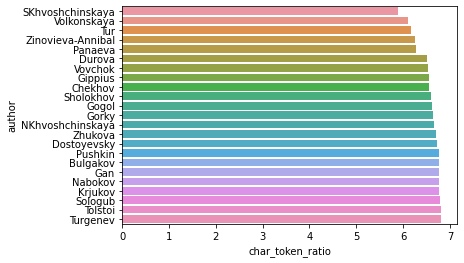

In [8]:
# This is the character-token ratio (as in Apples to Apple)
sns.barplot(data=author_groupby, y='author', x='char_token_ratio', order=author_groupby.sort_values('char_token_ratio').author)

<AxesSubplot:xlabel='type_token_ratio', ylabel='author'>

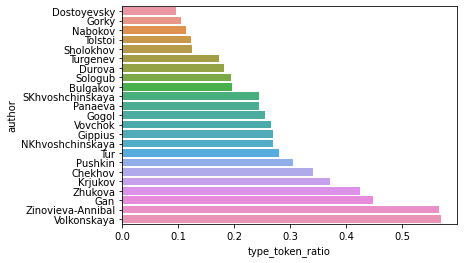

In [11]:
# This is the type-token ratio (as in Apples to Apple)
sns.barplot(data=author_groupby, y='author', x='type_token_ratio', order=author_groupby.sort_values('type_token_ratio').author)

In [12]:
# Just start by comparing pymystem to original 
stemmer = 'pymystem3'
stemmed_dir_path = Path(f'/home/virginia/workspace/topic-modeling-study/russian_novels_{stemmer}')
stemmed_lemma_counts_path = stemmed_dir_path / f'russian_novels_{stemmer}_lemma_counts.tsv'
# This gets the counds of all lemma/token pairs
stemmed_token_counts_by_author = pd.read_csv(stemmed_lemma_counts_path, sep='\t', header=0, encoding='utf-8')
print(len(stemmed_token_counts_by_author))
stemmed_token_counts_by_author.head()

839731


,author,token,normalized,count
0,Turgenev,было,быть,919
1,Turgenev,тихое,тихий,9
2,Turgenev,летнее,летний,3
3,Turgenev,утро,утро,58
4,Turgenev,солнце,солнце,42


In [13]:
stemmed_pruned_vocab = stemmed_dir_path / f'russian_novels_{stemmer}_pruned_vocab.txt'
kept_lemmas = get_token_list(stemmed_pruned_vocab)
stemmed_token_counts_by_author_pruned = stemmed_token_counts_by_author.loc[stemmed_token_counts_by_author['normalized'].isin(kept_lemmas)].copy()
stemmed_token_counts_by_author_pruned['stem_length'] = stemmed_token_counts_by_author_pruned['normalized'].str.len()
stemmed_token_counts_by_author_pruned['length_sum'] = stemmed_token_counts_by_author_pruned['stem_length'] * stemmed_token_counts_by_author_pruned['count']
print(len(stemmed_token_counts_by_author_pruned))
stemmed_token_counts_by_author_pruned.head()



741521
ipykernel_launcher:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipykernel_launcher:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,author,token,normalized,count,stem_length,length_sum
1,Turgenev,тихое,тихий,9,5,45
2,Turgenev,летнее,летний,3,6,18
3,Turgenev,утро,утро,58,4,232
4,Turgenev,солнце,солнце,42,6,252
6,Turgenev,довольно,довольно,185,8,1480


In [14]:
# What's overlap between pruned vocabularies? Does it look sane?
# TODO expand list of kept lemmas to tokens they cover, how many of those are kept? 
# Is more of the pruned vocab covered by lemmas or not?  
# What was thrown out that we're now keeping? (compare to stop list of original corpus)
# What lemmas are thrown out? 
vocab_overlap = pruned_vocab & kept_lemmas
print(len(vocab_overlap))
list(vocab_overlap)[:20]


16014


['изголовье',
 'осетров',
 'павловск',
 'крошечный',
 'бишь',
 'гневный',
 'тема',
 'фальшь',
 'полоскать',
 'наголо',
 'переночевать',
 'счастливый',
 'отбиваться',
 'мудрено',
 'постукивать',
 'поговорка',
 'арм',
 'нежный',
 'захожий',
 'пласт']

In [15]:
author_stem_groupby = stemmed_token_counts_by_author_pruned.groupby(['author']).agg({'count': ['sum'], 'length_sum':['sum']}).reset_index()
author_stem_groupby.columns = ['author', 'total_tokens', 'total_tokens_length']
author_stem_groupby['char_token_ratio'] = author_groupby['total_tokens_length'] / author_stem_groupby['total_tokens']
display(author_stem_groupby['char_token_ratio'].describe())
author_stem_groupby.head()

KeyError: 'total_tokens_length'

In [ ]:
sns.barplot(data=author_stem_groupby, y='author', x='char_token_ratio', order=author_stem_groupby.sort_values('char_token_ratio').author)

In [ ]:
# TODO join with original char_token_ratio dfs and plot by author as hue to compare changes